In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'true'
# Set this lower, to allow for PyTorch Model to fit into memory
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.90' 

import sys
package_path = os.path.dirname(os.path.dirname(os.getcwd())) 
sys.path.insert(0, package_path)
from glob import glob 

from wofscast.common.wofs_data_loader import WoFSDataLoader
from wofscast.evaluate.metrics import (
                                       Metric,
                                       MSE,
                                       ObjectBasedContingencyStats,
                                       PowerSpectra,
                                       FractionsSkillScore,
                                       PMMStormStructure,
                                       )

from wofscast.evaluate.predictor import Predictor
from wofscast.evaluate.object_ider import ObjectIder
from wofscast.evaluate.evaluator import Evaluator, EvaluatorConfig 

import numpy as np

In [2]:
base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/2021'
#base_path = '/work2/mflora/wofscast_datasets/dataset_10min_full_domain_test/2021'
model_path = '/work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz'

config = EvaluatorConfig(
    data_path = os.path.join(base_path, '*_ens_mem_09.zarr'),
    n_samples = 5,
    seed = 42,
    model_path = model_path,
    add_diffusion = False,
    load_ensemble = False,
    spectra_variables = ['COMPOSITE_REFL_10CM', 'T2', 'W'],
    pmm_variables = ['COMPOSITE_REFL_10CM', 'T2', 'RAIN_AMOUNT', 'WMAX'],
    fss_variables = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT'],
    fss_windows = [7, 15, 27],
    fss_thresh_dict = {'COMPOSITE_REFL_10CM' : [40.0], 
                       'RAIN_AMOUNT' : [25.4/2], # 0.5 in
                       },
    matching_distance_km = 42 ,
    grid_spacing_km=3.0,
    out_base_path = '/work2/mflora/test_output',
    object_id_params =  {
        "forecast": {
            "COMPOSITE_REFL_10CM": 47.0,
            "WMAX": 10.0
        },
        "truth": {
            "COMPOSITE_REFL_10CM": 47.0,
            "WMAX": 10.0
        },
        "mrms": {
            "dz_consv": 40.0
        }
    }
)

In [4]:
from skimage.measure import regionprops_table

class ObjectProperties(Metric):
    def __init__(self, properties=()):
        super().__init__() 
    
    def update(self, forecast, truth):
        # time, batch, lat, lon -> lat, lon
        t=1
        
        forecast_t= forecast.isel(time=t).squeeze(dim='batch')
        truth_t = truth.isel(time=t).squeeze(dim='batch')
        
        forecast_intensity = forecast_t['COMPOSITE_REFL_10CM'].values
        truth_intensity = truth_t['COMPOSITE_REFL_10CM'].values 
        
        forecast_storms = forecast_t['storms'].values.astype(int)
        truth_storms = truth_t['storms'].values.astype(int)
        
        forecast_regionprops = regionprops_table(forecast_storms, forecast_intensity, 
                                                properties=self.properties)
        
    def finalize(self):
        pass
        
    

In [3]:
# Selecting a single ensemble member. 
paths = glob(config.data_path)
paths.sort()
n_samples=config.n_samples

rs = np.random.RandomState(config.seed)
random_paths = rs.choice(paths, size=n_samples, replace=False)[:2]


model = Predictor(
    model_path = config.model_path,
    add_diffusion=config.add_diffusion 
)

data_loader = WoFSDataLoader(model.task_config, 
                             model.preprocess_fn, 
                             config.load_ensemble, 
                             model.decode_times)  

object_ider = ObjectIder()

metrics = [MSE(),  
           
           ObjectBasedContingencyStats(config.matching_distance_km / config.grid_spacing_km), 
           
           PowerSpectra(variables=config.spectra_variables),
           
           FractionsSkillScore(windows=config.fss_windows, 
                               thresh_dict=config.fss_thresh_dict,
                             variables = config.fss_variables),
           
           PMMStormStructure(config.pmm_variables),
           ObjectProperties 
           
           ]

mrms_variables = ['accum_rain']
targets_v_mrms_metrics = [
                            FractionsSkillScore(windows=[7, 15, 27], 
                                             # Forecast, MRMS thresholds    
                                             thresh_dict={'COMPOSITE_REFL_10CM' : [(47.0, 40.0)], 
                                                          'accum_rain' : [0.5], 
                                                         },
                                             variables = ['COMPOSITE_REFL_10CM', 'accum_rain'],
                                             addon='targets_vs_mrms'              
                                                          ),
                            ObjectBasedContingencyStats(key='targets_vs_mrms'),
                            MSE(addon='targets_vs_mrms', variables=mrms_variables), 
]

forecast_v_mrms_metrics = [ 
                          FractionsSkillScore(windows=[7, 15, 27], 
                                              # Forecast, MRMS thresholds  
                                            thresh_dict={'COMPOSITE_REFL_10CM' : [(47.0, 40.0)],
                                                         'accum_rain' : [0.5], 
                                                        },
                                             variables = ['COMPOSITE_REFL_10CM', 'accum_rain'],
                                             addon='forecast_vs_mrms'             
                                                           ),
                          ObjectBasedContingencyStats(key='forecasts_vs_mrms'),
                          MSE(addon='forecast_vs_mrms', variables=mrms_variables),
                                        ]

# Metrics for comparing against an analysis dataset 
targets_v_analysis_metrics = [MSE(addon='targets_vs_analysis')]
forecast_v_analysis_metrics = [MSE(addon='forecast_vs_analysis')]

Setting legacy_mesh = True in predictor.py


In [4]:
%%time
evaluator = Evaluator(model, object_ider, data_loader, metrics, 
                      config.object_id_params,
                      forecast_v_mrms_metrics, 
                      targets_v_mrms_metrics, 
                      forecast_v_analysis_metrics,
                      targets_v_analysis_metrics,
                     )
results_ds = evaluator.evaluate(random_paths)
evaluator.save(results_ds, config)

  0%|                                                                                                                                         | 0/2 [00:00<?, ?it/s]WARNING:absl:Skipping gradient checkpointing for sequence length of 1


f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thre

 50%|████████████████████████████████████████████████████████████████▌                                                                | 1/2 [00:15<00:15, 15.82s/it]WARNING:absl:Skipping gradient checkpointing for sequence length of 1


f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=40.0 o_thresh=40.0
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thresh=12.7
f_thresh=12.7 o_thre

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.75s/it]

Saved results dataset to /work2/mflora/test_output/wofscast_test_v178_results_v6.nc!
CPU times: user 2min 14s, sys: 12.7 s, total: 2min 27s
Wall time: 27.6 s


'Saved results dataset to /work2/mflora/test_output/wofscast_test_v178_results_v6.nc!'

In [5]:
import xarray as xr
ds = xr.load_dataset('/work2/mflora/test_output/wofscast_test_v178_results.nc')

In [6]:
ds.attrs

{'data_path': '/work/mflora/wofs-cast-data/datasets_2hr_zarr/2021/*_ens_mem_09.zarr',
 'n_samples': '5',
 'seed': '42',
 'model_path': '/work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz',
 'add_diffusion': 'False',
 'load_ensemble': 'False',
 'spectra_variables': "['COMPOSITE_REFL_10CM', 'T2', 'W']",
 'pmm_variables': "['COMPOSITE_REFL_10CM', 'T2', 'RAIN_AMOUNT', 'WMAX']",
 'fss_variables': "['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT']",
 'fss_windows': '[7, 15, 27]',
 'fss_thresh_dict': "{'COMPOSITE_REFL_10CM': [40.0], 'RAIN_AMOUNT': [12.7]}",
 'matching_distance_km': '42',
 'grid_spacing_km': '3.0',
 'out_base_path': '/work2/mflora/test_output',
 'object_id_params': "{'forecast': {'COMPOSITE_REFL_10CM': 47.0, 'WMAX': 10.0}, 'truth': {'COMPOSITE_REFL_10CM': 47.0, 'WMAX': 10.0}, 'mrms': {'dz_consv': 40.0}}"}

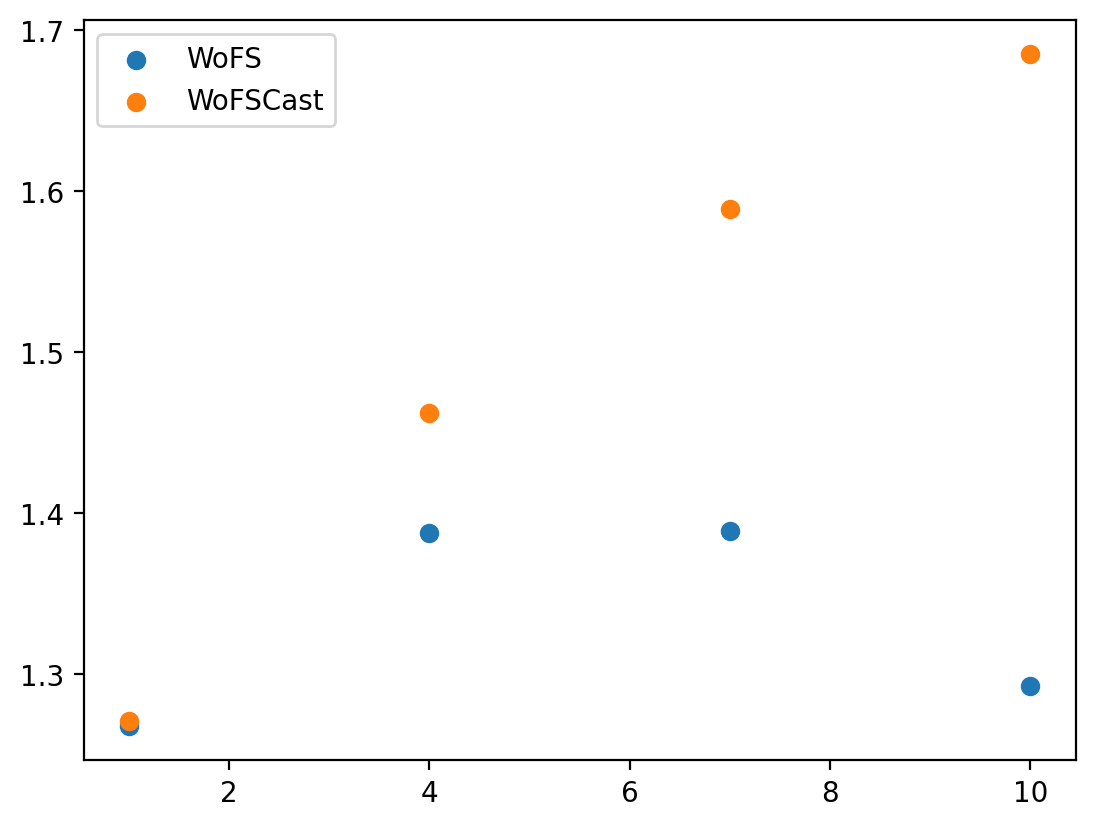

In [7]:
import matplotlib.pyplot as plt

wofs = results_ds['T2_rmse_targets_vs_analysis'].values
wofs[wofs==0] = np.nan

wofscast = results_ds['T2_rmse_forecast_vs_analysis'].values
wofscast[wofscast==0] = np.nan
times = np.arange(len(results_ds.time.values))

fig, ax = plt.subplots(dpi=200)

ax.scatter(times, wofs, label='WoFS')
ax.scatter(times, wofscast, label='WoFSCast')

ax.legend() 

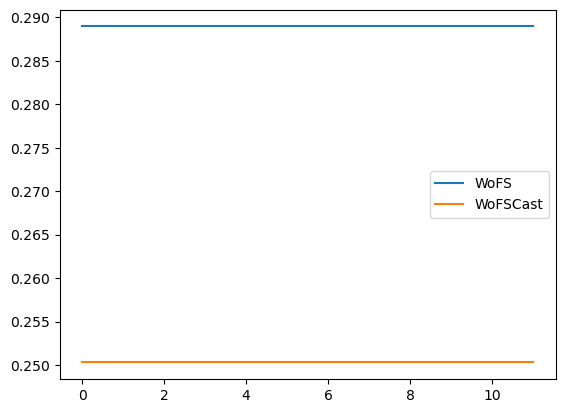

In [8]:
fig, ax = plt.subplots()


ax.plot(times, 
        results_ds['accum_rain_fss_targets_vs_mrms'].isel(window=-1).values, label='WoFS')
ax.plot(times, 
        results_ds['accum_rain_fss_forecast_vs_mrms'].isel(window=0).values, label='WoFSCast')
ax.legend() 

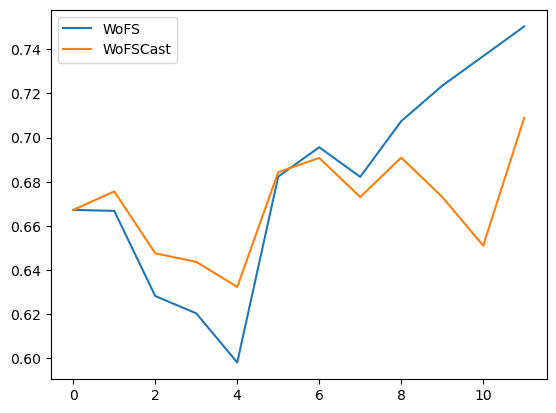

In [9]:
fig, ax = plt.subplots()


ax.plot(times, 
        results_ds['COMPOSITE_REFL_10CM_fss_targets_vs_mrms'].isel(window=-1).values, label='WoFS')
ax.plot(times, 
        results_ds['COMPOSITE_REFL_10CM_fss_forecast_vs_mrms'].isel(window=-1).values, label='WoFSCast')
ax.legend() 

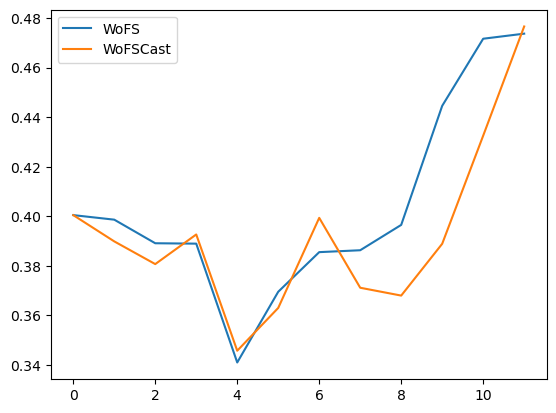

In [10]:
fig, ax = plt.subplots()


ax.plot(times, 
        results_ds['COMPOSITE_REFL_10CM_fss_targets_vs_mrms'].isel(window=0).values, label='WoFS')
ax.plot(times, 
        results_ds['COMPOSITE_REFL_10CM_fss_forecast_vs_mrms'].isel(window=0).values, label='WoFSCast')
ax.legend() 

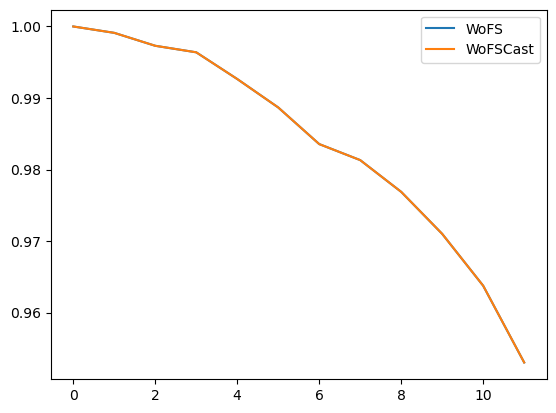

In [11]:
fig, ax = plt.subplots()


ax.plot(times, 
        results_ds['COMPOSITE_REFL_10CM_fss'].isel(window=-1).values, label='WoFS')
ax.plot(times, 
        results_ds['COMPOSITE_REFL_10CM_fss'].isel(window=-1).values, label='WoFSCast')
ax.legend() 

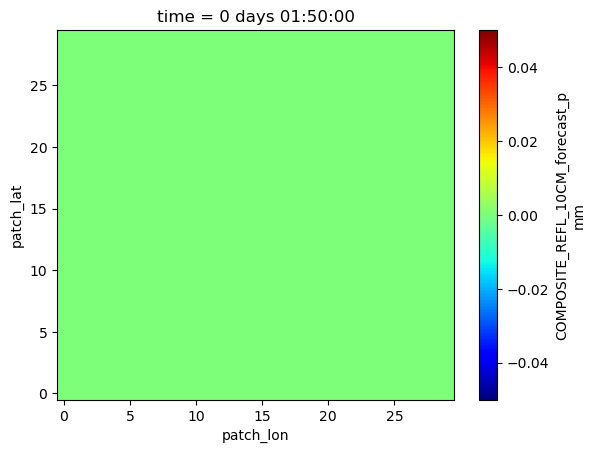

In [12]:
results_ds['COMPOSITE_REFL_10CM_forecast_pmm'].isel(time=-1).plot(cmap='jet') 

In [13]:
results_ds

<xarray.Dataset>
Dimensions:                                        (time: 12, wave_num: 75,
                                                    window: 3, thresholds: 1,
                                                    patch_lat: 30, patch_lon: 30)
Coordinates:
  * time                                           (time) timedelta64[ns] 00:...
  * wave_num                                       (wave_num) float64 0.01333...
  * window                                         (window) int64 7 15 27
Dimensions without coordinates: thresholds, patch_lat, patch_lon
Data variables: (12/80)
    U_rmse                                         (time) float32 0.0 ... 1.725
    V_rmse                                         (time) float32 0.0 ... 1.794
    W_rmse                                         (time) float32 0.0 ... 0.2526
    T_rmse                                         (time) float32 0.0 ... 1.336
    GEOPOT_rmse                                    (time) float32 0.0 ... 61.56
    QVAPOR_rmse                                    (time) float32 0.0 ... 0.0...
    ...                                             ...
    forecasts_vs_mrms_false_alarms                 (time) float32 0.0 ... 0.0
    forecasts_vs_mrms_pod                          (time) float32 0.0 ... 0.0
    forecasts_vs_mrms_sr                           (time) float32 nan ... nan
    forecasts_vs_mrms_csi                          (time) float32 0.0 ... 0.0
    forecasts_vs_mrms_fb                           (time) float32 nan ... nan
    accum_rain_rmse_forecast_vs_mrms               float64 6.826
Attributes: (12/15)
    data_path:             /work/mflora/wofs-cast-data/datasets_2hr_zarr/2021...
    n_samples:             5
    seed:                  42
    model_path:            /work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz
    add_diffusion:         False
    load_ensemble:         False
    ...                    ...
    fss_windows:           [7, 15, 27]
    fss_thresh_dict:       {'COMPOSITE_REFL_10CM': [40.0], 'RAIN_AMOUNT': [12...
    matching_distance_km:  42
    grid_spacing_km:       3.0
    out_base_path:         /work2/mflora/test_output
    object_id_params:      {'forecast': {'COMPOSITE_REFL_10CM': 47.0, 'WMAX':...

In [14]:
results_ds['T2_rmse_targets_vs_analysis']

<xarray.DataArray 'T2_rmse_targets_vs_analysis' (time: 12)>
array([      nan, 1.2679243,       nan,       nan, 1.3877661,       nan,
             nan, 1.3887701,       nan,       nan, 1.2925696,       nan],
      dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:10:00 ... 01:40:00 01:50:00

In [15]:
results_ds['T2_rmse_forecast_vs_analysis']

<xarray.DataArray 'T2_rmse_forecast_vs_analysis' (time: 12)>
array([      nan, 1.2712722,       nan,       nan, 1.4621892,       nan,
             nan, 1.5887923,       nan,       nan, 1.6852385,       nan],
      dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:10:00 ... 01:40:00 01:50:00